[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joonbugs/PAS4AI-Summer-24/blob/main/PAS4AI_Day6.ipynb)

# LLM Rules:
You may freely use the discord bots that the instructors provide or your own. You should tell the instructors how you used them at each instructor check-in.

# After each task, have an instructor look!

## 0. Run
- Run the notebook as-is
- Make sure you can see your bot online in #pans-playground
- Send a test message to it in #pans-playground

## 1. Read the Code
- Look at Sections
- Find the entry point
- Ping @Instructor - We’ll join and have you explain it.

## 2. Convert the API call to sync
- Stop the bot first and do this in the bottom cell
- An LLM can help with this!
- Ping @Instructor - Show us some calls with different data.

## 3. Look at a new model


Skim this link:  https://stablediffusionxl.com/

- What does the model do?
- What are the inputs and the outputs?


Read this whole page:  https://docs.aws.amazon.com/bedrock/latest/userguide/model-parameters-diffusion-1-0-text-image.html


- Ping @Instructor in #live - Explain to us

## 4. Implement `text2img_response_sync` in Sync Playground Part 2


## 5. Change it to Sync


In [ ]:
#@title Install Modules
!pip install py-cord httpx

In [2]:
#@title Helper Functions (IGNORE THIS)

import base64
from io import BytesIO
from PIL import Image

def show_b64_image(base64_bytes):
    image_data = base64.b64decode(base64_bytes)
    image = Image.open(BytesIO(image_data))
    display(image)

import re
from collections import namedtuple


class Node(namedtuple("Node", ["type", "content", "children"])):
    def __str__(self):
        return self.to_markdown()

    def to_markdown(self):
        if self.type == "text":
            return self.content
        else:
            wrapper = MARKDOWN_MAP.get(self.type, ("", ""))
            return (
                wrapper[0] + "".join(str(child) for child in self.children) + wrapper[1]
            )


MARKDOWN_MAP = {
    "bold": ("**", "**"),
    "italic": ("*", "*"),
    "underline": ("__", "__"),
    "strikethrough": ("~~", "~~"),
    "code": ("`", "`"),
    "codeblock": ("```", "```"),
}

PATTERNS = [
    (re.compile(r"\*\*(.*?)\*\*"), "bold"),
    (re.compile(r"\*(.*?)\*"), "italic"),
    (re.compile(r"__(.*?)__"), "underline"),
    (re.compile(r"~~(.*?)~~"), "strikethrough"),
    (re.compile(r"`(.*?)`"), "code"),
    (re.compile(r"```(.*?)```", re.DOTALL), "codeblock"),
]


def parse_markdown(text):
    if len(text) > 2000:
        return split_large_text(text, "text")
    for pattern, style in PATTERNS:
        match = pattern.search(text)
        if match:
            before = text[: match.start()]
            content = match.group(1)
            after = text[match.end() :]
            return Node(
                "root",
                "",
                [
                    parse_markdown(before),
                    Node(style, "", [parse_markdown(content)]),
                    parse_markdown(after),
                ],
            )
    return Node("text", text, [])


def split_large_text(text, node_type):
    """
    Splits text into manageable parts without breaking format within the 2000 character limit.
    """
    chunks = []
    if node_type == "text":
        preferred_split = "\n"
    else:
        preferred_split = (
            "\n"  # Optionally, choose other delimiters for different node types.
        )

    # Split by preferred method and ensure each part is under the limit
    parts = text.split(preferred_split)
    current_chunk = ""
    for part in parts:
        if len(current_chunk + part) > 2000:
            if current_chunk:
                chunks.append(Node(node_type, current_chunk, []))
            current_chunk = part + preferred_split  # Keep structure where possible
        else:
            current_chunk += part + preferred_split

    if current_chunk:
        chunks.append(Node(node_type, current_chunk.rstrip(preferred_split), []))
    return Node("root", "", chunks)


def split_ast_to_chunks(node, limit=2000):
    chunks = []
    current_chunk = []

    def flush_current_chunk():
        if current_chunk:
            chunks.append(Node("root", "", current_chunk.copy()))
            current_chunk.clear()

    def add_node_to_chunk(node):
        current_size = len(flatten_ast(Node("root", "", current_chunk)))
        node_str = str(node)
        if current_size + len(node_str) > limit:
            flush_current_chunk()
        current_chunk.append(node)

    # Recursively add nodes
    def add_to_chunk(subnode):
        if subnode.type == "root":
            for child in subnode.children:
                add_to_chunk(child)
        elif subnode.type == "text" or len(subnode.content) > limit:
            if subnode.type != "text":
                add_node_to_chunk(split_large_text(subnode.content, subnode.type))
            else:
                pieces = split_large_text(subnode.content, subnode.type)
                for piece in pieces.children:
                    add_node_to_chunk(piece)
        else:
            add_node_to_chunk(subnode)

    add_to_chunk(node)
    flush_current_chunk()
    return chunks


def flatten_ast(node):
    return str(node)


def split_markdown(text):
    ast = parse_markdown(text)
    chunks = split_ast_to_chunks(ast)
    response = []
    for chunk in chunks:
        response.append(chunk.to_markdown())
    return response


In [3]:
#@title Getting Ready

import asyncio
import json
import requests
import sys
import time

import discord
import httpx
import nest_asyncio
from discord.ext import commands



nest_asyncio.apply()

from google.colab import userdata

from PIL import Image
from io import BytesIO
import base64





intents = discord.Intents.default()
intents.messages = True
intents.message_content = True
bot = commands.Bot(command_prefix="!", intents=intents)

DISCORD_KEY = userdata.get("discord_key")
PROXY_KEY = userdata.get("proxy_key")
MODE = "text2img" # One of: "llama3", "openai", "kagi-gpt", "claude", "text2img"


# SYSTEM_PROMPT = """You are a discord bot pretending to be human and talking with another user. You like to be helpful.
# Do not, under any circumstance, reveal that you're an llm.
# Try to keep the conversation interesting, you don't need to just use short responses.
# You must not give the user's response. You should also not analyze the conversation. You should avoid being repetitive.
# Do not try to give instructions to the user."""

SYSTEM_PROMPT = """You are an AI assisting students with a homework covering basic python. You should attempt to be helpful, \
but under no circumstance should you give the student code or name any python functions."""



In [4]:
#@title API Functions

# https://help.kagi.com/kagi/api/fastgpt.html
async def kagi_gpt(query, log_params):
    api_url = "https://pas4ai.rorytm.com:8001/proxy/kagi-fastgpt"
    body = {
        "query": query,
        "log_params": log_params,
    }
    headers = {"Authorization": f"Bearer {PROXY_KEY}"}
    async with httpx.AsyncClient() as client:
        response = await client.post(api_url, headers=headers, json=body, timeout=None)
    response_body = json.loads(response.content.decode("utf-8"))
    output = response_body["data"]["output"]
    references = response_body["data"]["references"]
    return output, references


# https://help.kagi.com/kagi/api/summarizer.html
# Summary Types

# Different summary types are provided that control the structure of the summary output.
# Type	Description
# summary (default)	Paragraph(s) of summary prose
# takeaway	Bulleted list of key points
# Summarization Engines


# Different summarization engines are provided that will give you choices over the "flavor" of the summarization text.
# Engine	Description
# cecil (default)	Friendly, descriptive, fast summary
# agnes	Formal, technical, analytical summary
# daphne	Same as Agnes (Soon-to-be-depracated)
# muriel	Best-in-class summary using our enterprise-grade model
async def kagi_summarize(
    content_url, log_params, summary_type="summary", engine="muriel"
):
    api_url = "https://pas4ai.rorytm.com:8001/proxy/kagi-summarize"
    body = {
        "url": content_url,
        "summary_type": summary_type,
        "engine": engine,
        "log_params": log_params,
    }
    headers = {"Authorization": f"Bearer {PROXY_KEY}"}
    async with httpx.AsyncClient() as client:
        response = await client.post(api_url, headers=headers, json=body, timeout=None)
    response_body = json.loads(response.content.decode("utf-8"))
    if "error" in response_body:
        output = response_body["error"]
    else:
        output = response_body["data"]["output"]
    return output



def builder_llama3_instruct(system: str | None, dialogue: list[dict]) -> str:
    # https://github.com/meta-llama/llama3/blob/main/llama/tokenizer.py#L202
    prompt = "<|begin_of_text|>"
    if system is not None:
        prompt += f"<|start_header_id|>system<|end_header_id|>\n\n{system}<|eot_id|>"
    for d in dialogue:
        prompt += f"<|start_header_id|>{d['role']}<|end_header_id|>\n\n{d['content']}<|eot_id|>"
    prompt += "<|start_header_id|>assistant<|end_header_id|>\n\n"
    return prompt


async def llama3_response(system, dialogue, log_params, model=70):
    prompt = builder_llama3_instruct(system, dialogue)
    api_url = f"https://pas4ai.rorytm.com:8001/proxy/bedrock/meta.llama3-{model}b-instruct-v1:0"
    body = {
        "prompt": prompt,
        "max_gen_len": 2048,
        "temperature": 0.5,
        "top_p": 0.9,
        "log_params": log_params,
    }
    headers = {"Authorization": f"Bearer {PROXY_KEY}"}
    async with httpx.AsyncClient() as client:
        response = await client.post(api_url, headers=headers, json=body, timeout=None)
    response_body = response.content.decode("utf-8")
    response_json = json.loads(response_body).get("generation")
    return response_json


async def openai_response(system, dialogue, log_params, model="gpt-4o"):
    url = "https://pas4ai.rorytm.com:8001/proxy/openai"
    body = {
        "max_tokens": 4096,
        "stream": False,
        "model": model,
        "temperature": 1,
        "presence_penalty": 0,
        "top_p": 1,
        "frequency_penalty": 0,
        "messages": [{"role": "system", "content": system}] + dialogue,
        "log_params": log_params,
    }
    headers = {"Authorization": f"Bearer {PROXY_KEY}"}
    async with httpx.AsyncClient() as client:
        response = await client.post(url, headers=headers, json=body, timeout=None)
    response_body = response.content.decode("utf-8")
    response_json = json.loads(response_body)["choices"][0]["message"]["content"]
    return response_json

async def text2img_response(content):
    print(f"{content=}")
    base64_bytes = b"iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAABhGlDQ1BJQ0MgcHJvZmlsZQAAKJF9kT1Iw1AUhU/TSotWHOwg4pChOlkQFXHUKhShQqgVWnUweekfNDEkKS6OgmvBwZ/FqoOLs64OroIg+APi6OSk6CIl3pcUWsR44fE+zrvn8N59gNCoMs0KjQGabpuZVFLM5VfE8Ct6EEAIEYgys4xZSUrDt77uqZfqLsGz/Pv+rF61YDEgIBLPMMO0ideJpzZtg/M+cYyVZZX4nHjUpAsSP3Jd8fiNc8llgWfGzGxmjjhGLJY6WOlgVjY14kniuKrplC/kPFY5b3HWqjXWuid/YbSgLy9xndYQUljAIiSIUFBDBVXYSNCuk2IhQ+dJH/+g65fIpZCrAkaOeWxAg+z6wf/g92yt4sS4lxRNAl0vjvMxDIR3gWbdcb6PHad5AgSfgSu97d9oANOfpNfbWvwI6NsGLq7bmrIHXO4AA0+GbMquFKQlFIvA+xl9Ux7ovwW6V725tc5x+gBkaVbpG+DgEBgpUfaaz7sjnXP7t6c1vx/69HJ3FGcNLgAAAAZiS0dEAAAAAAAA+UO7fwAAAAlwSFlzAAAuIwAALiMBeKU/dgAAAAd0SU1FB+YLAQQKGC0v3EsAAAAZdEVYdENvbW1lbnQAQ3JlYXRlZCB3aXRoIEdJTVBXgQ4XAAALGUlEQVR42t2beXBV9RXHv+f3u/e+JXnZIIADRSkCAiIgsrZFhAgkIaxZAevWTt3YRBEBnemUZVxZymBnrFIoRELYZBekWiwUBEQqyDrSquwhZM+72+/0D6kNSCDk5T2W8++979yczzu/s3zvC3Cb25qneus7nuluVHedbsegtzzXne7QKjtEc9lQwc4IhvCf1ps07fzWVuvye7XbKfCDYzvc7UdFulSnH5HKaQPwj9fYdu4F8MVtB+Dg8/c38rslIwV4uFTn2xNYXOm+aM+Vk/2WBHBgTPuGfpjDNFiZ0in4JUHJa31GCNzaAD4f3SUhUZSmaWwOlXwhmaD06/l8NfHf3AD2PN/dn6CK+kplPiFxJlUoV9TaGd0iAI6Naa0TKFWHlSndUwMEO4G68Es3cwZs+V0nranXfMgDM12icrBgp0GdP+Rmy4BNT3UWzXzBB7yqIotQOEKy3TCMj2O4TulNAeDAqHZdAiKYKVCQIV2nadVeHZ7Ihe1Cvt3i9Z1Hb9gkeHhc+9Y+VZENVtk6rJYRCNpxSd/mQMsvQ/TydrP3nI74KHz4+Q53et2KHAFnpGS7LYU/aHagH3ShLYbUFzabuf/7UIpjrezQuPubeFV5pgY7XbDTnaDCnFsEF9ohRXJBOQWWtZ6191hddYca275xnRPjuGSwZCtbsPtgTaayUM0l44jD2moLxuKjZf59qe9/zrVHWJtePfqeGI3UUAl3hGTnQYKrhz1o6Cdc0lY4rC9uPufrnWHujj+1z57tEttYL0vR2Rwm2EkRcH0RCLoQRLlBisorQmD7A7O2q7o/RFex7aO6eO6QJUkGmyPAKl1E4JtWpF9QEKtMeJeedOM+6Tl3mxmKvzET5rZXwrjTS+baN2aMUtecA06OaymDrD0slfW4RuceFsqOD3vQ0CpcyHUu6XlB+Fa3nr3Xrq2vsa/MJ2VVtlCgkURymEuiNQAKWqovgM1XBXDsxa6kzDOrfahIudhbwhi0tBW0jTYZiytE1Np7Z+4uD8XfqPEzm0HzDXUdZzgLowMAUfXP1+E2uOYkqN+X1KleQKY4ZWWwzp2EdeoQECyou15N0nZZ+9QhPa8YgVUdZu86H1J6vzinoZLeDBClM9AToGqPtKAaCCKO8DTXdAEtPgHe+ATw3W1hlhTBOnui1jAYAi607Q7p+UF4F7Wesy8komMmzktQpA1gpR51hfwVQDWqS6I2yxAJgjcuHt64eHCLtrBKS2AVnIZ18gi4/MRVgiY4MPaw0BaVKv+Ke+fs/Tak9H5hVgBCT4PQMl2S/QB4q5V4qusowpAhLUNEBE9MLDwxseBmLWGVlcI6exLWqaMXYRC7pO+3WVtXSb6FbWbvOxhK0KNfmO2B0PqzNLIYGABQSLqAKTy+OtsGiQieQAw8gRjwz1vBqawEM+80oqJfI0FbtORJpbXxO+6lPxouGT0ZNFwBQ0AiLtwdKOR1mIig+/0A0A3glay42Fw79WNHYbnLtDZm0OSrwhg/aZ6wHPQAyWybKB0kwqILEFhFSg+IFYRhhsQwxVxhrZu6iYAVRLReS5l8HgDGTpkvlGPez6Ask0U6JN0V7qFSc81d126DEnZdPlUQ/AAGAxjMzJWnlk7/bNa++CPljpMK0ppFQIpQxO5eYjVt5uvPfXlNAPX84iAAhepV5Ou2ckvg6AUPvjzn9X1VZPRVoL5hl2FY7SdgiXQq82a9OeZYjWuA19AO2Y7zewG8SITo2j4/6BC+ueDBvwq82FPogcPhF56I1VGwyoNjLncqy/e9M28S16w2XMFKP5wWIwX30wWGAEgBEHstR7YLHC/y4ouzXuy94IGlIqC2sfqeWK0kogWke/bO/sNj6vqL4zXM2TDd57qqDzPSBSGNCAn/D5rwn2IDB8578XmBBxWuiMCx5rPEvEwoe4mUYtvbM54OaUW+rq+paNU0b4VFgwsqPG/+u0Rv/I+z3ogE3cDjoGuiiSbR5j8bx9jjA365U/abWCfaQI0AjJs4z+ew6MvACAiZDFB0uIOO1Vx0STTRoUElGkXbl8/yhx2Fda5CXpRP2019aw+Dql86/qSxcpJYGNlMNBCgsOsCMZpCt8QgWtcL4mcxFmQNkksxjhOwigStJBI7tOSX7ZAAjJ04r5EL+SqDMkCifriD9kuFTgkm2iUGcWesBUOGJEJ85zI22i7yXIitcYMm2dcF4LWnHiH3rqRd5TY6lVTYYdNDdGJ0iLfQsUElmseboQZdXWacY2C5JFojhNgsq8mMSwDkr9wepxgXQATLDKLwQinOFRajpMysA4WfQcCuNjHWJ1mtipOiPaojRejNFAMHBFFPLWVy4U+m1UsVG6H9T1QxPF40apSIdm3uRteOLXBPs4aoH+OtVlioVgRitZ+U8yqZ5W3gmF2ffvnZl+L89IDloqWjMEkxdl+cPsM3JAFtbZczar0MabqBxMT6SEysD8e2cKGoFAWFxSgsqYTiK05l3zCrZYKwSOie/bP+8Pgld4n+LzOAYwBmAJhhr5vWlJkHAsgAoQeFYUkrNfmOOtkGf4BRD4mJ9eA6DoqLS1BQWILCorLTjkKucIN5Qlm7Zr41vsYHW0+d/C2AuQDmlnw4tbEuMEgQMgWhGwBPXQAwZBj0AKlpSKiXgIR6CWClAszclJVzV7Cy7GsAZbVqhYOmnAAwD8A8Z/20RKU4hYEMIvQhwFvrwiuvrB1ecqKXrtpRn5nPhV51uJxZbYRy84l4bVZ6r/JQXRaunJrg05AmCOmC0Au47mVtlp46ZVxkAFzCQgWVUlvBnGeb5asfHZkcss7urJ8eq1j1BpDBjAGCEKgTAHkrt8WCqegq8nqoNGxm9TdmtYwda9Xw7KSQYZxdPi0qWud+QiBTEvoAqF9rAAsWbybD69sphOwc/ubMtqvc3axUvnLt/Edykr4POTM2TPezUj0ZGMKMwYLw49sgV+ENb9qUCdcchRct2dJA1z2jGcgmIZtHYlABs2LmHWCVrxxzxfDspG9DdWmtn6GbtttLF8ggQhdHYXTUwClba7wM/fndfOGNjusoNU8GSKQLGSEYgGLl7lNKrbTt4DLDE3UoZ9gvwvaWskaHfcPfj1PhiSNtpMc/GBDpRNQhbHXi0swAM38FqHx27WU5mb0P3hAAPzkmuR+1kro3HSQyhNTuQ2RmemblHlas1ri2lV9aVrznmd8OUzcEQFWb/5c1Lf2BuP74YX3uASIRkbKh3OMAL2Pl5mve2N0ZaR35hgCoarlLNjcmaQwDiUwhZDcQyQjB+E4xr3MdK98KVnz25GNp9g0BUNXem7+6cXQgrh+ESAdEHxAZEWooZ1iplVDOMmn4Ps0c3M29IQCq2uLFG+oJw58GElkkRG8iEREYYHXGVepjAr+Tk95z2w0DUNXefX91QlR0IFlKfRBIJIPCL7CCmZVrpeRk9Np4wwFUtb8uXB2l+WKSiWQGSKSQEGGEwW9kDekx4aYCUNUW5m72C6J+uuFNBdEQkEioS/+2Zb43MqvXb25aAJe01vdWGN5A/EMktEwQDSQhQ1anzWBF7q9z+oyoU0EkXPb4k0MtAB8B+Gjh4k06EXoZHn8yiDJAokmt+n01k+st9Z+jS1ftFE6wtBtpRiaRGEJCNq3xETArc0dm9x5xSwO45JgsWCeEFN28vkB/EDJAstXV4nGsYO6IrIduHwCX2wd5W9pBaJk/bK7aPZdfd61g7vArABC3C4CcrD5f5WQ8+ErhuZNtKsuK2kM5E8Dublz8cRQJUXzL14Ba7ScfbGomNKNPRUX5liceTT1++fX/Am9zpgf9WJY9AAAAAElFTkSuQmCC"
    text = None
    return base64_bytes, text

In [5]:
#@title The Bot

@bot.event
async def on_ready():
    print(f"Logged in as {bot.user.id}")

    discordbot_to_name = {
      1252372433076486144: 'Ema',
      1252373858221293578: 'DavidK',
      1252374806058369035: 'Fareed',
      1252393385063616572: 'Dahlia',
      1252406583103852777: 'Jack',
      1252423513164349531: 'RoryH',
      1252433109849342083: 'Elliot',
      1252435744992264294: 'Char',
      1252454401742868541: 'Jasmine',
      1252492962106179656: 'Joshua',
      1253329578491904070: 'Katherine',
      1252356806924177408: 'Michael',
      1252640101780164618: 'DavidO',
      1252777236189282404: 'Jaiden',
      1253087012781821962: 'Timothy',
      1253024298273341483: 'Ben',
      1232346658000601168: 'DEMO',
      1254555362657570857: 'Salcilia'
    }

    if bot.user.id in discordbot_to_name:
      name = discordbot_to_name[bot.user.id]
    else:
      name = "UNKNOWN"

    await bot.user.edit(username=f"{name}'s Bot")
    print(f"Set name to {bot.user}")

def b64_to_file(b64string, filename):
  less_logo = base64.b64decode(b64string)
  with open(filename, "wb") as f:
    f.write(less_logo)


async def handle_request(message, message_hist, log_params):
    match MODE:
        case "llama3":
            response = await llama3_response(
                SYSTEM_PROMPT, message_hist, log_params
            )
            return response
        case "openai":
            response = await openai_response(
                SYSTEM_PROMPT, message_hist, log_params
            )
            return response
        case "text2img":
            base64_image, response = await text2img_response(message.content)
            await send_image(base64_image, message.channel.send)
            return response
        case "kagi-gpt":
            query = message.content
            output, references = await kagi_gpt(query, log_params)
            response = output
            for ref in references:
                response += "\n\n" + str(ref)
            return response
        case _:
            raise ValueError("Unknown mode")


async def send_response(response, method):
    if len(response) > 2000:
        chunks = split_markdown(response)
        for chunk in chunks:
            await method(chunk)
    else:
        await method(response)


async def send_image(b64_image, method):
    b64_to_file(b64_image, "tmp.png")

    with open("tmp.png", "rb") as f:
      files = [discord.File(f)]
    await method(files=files)



def truncate_message_hist(size: int, message_hist: list[dict]) -> dict:
    result = []
    current_size = 0
    # print(f"{message_hist=}")
    for message in message_hist[::-1]:
      current_size = current_size + len(message['content'])
      if current_size > size:
        break
      result.append(message)
    result = result[::-1]
    # print(f"{result=}")
    return result

@bot.event
async def on_message(message):
    if message.author == bot.user:
        return

    log_params = {"bot_id": bot.user.id, "user_id": message.author.id}

    # For mentions in the parent channel, create the thread first and respond there.
    if message.mentions and bot.user in message.mentions and not message.is_system():
        thread = await message.create_thread(
            name=f"{round(time.time())}",
            auto_archive_duration=60,
        )
        log_params["channel"] = message.channel.id
        log_params["thread"] = thread.id
        message_hist = [{"role": "user", "content": message.content}]
        response = await handle_request(message, message_hist, log_params)
        await send_response(response, thread.send)

    # If we're already in a thread...
    if (
        isinstance(message.channel, discord.Thread)
        and message.channel.owner_id == bot.user.id
    ):
        if message.author != bot.user:
            log_params["channel"] = message.channel.parent_id
            log_params["thread"] = message.channel.id
            message_hist = []
            first = True
            async for msg in message.channel.history(limit=50, oldest_first=True):
                if first:
                    msg = await message.channel.parent.fetch_message(
                        message.channel.id
                    )
                    first = False

                if msg.author == bot.user:
                    role = "assistant"
                else:
                    role = "user"
                message_hist.append({"role": role, "content": msg.content})
            message_hist = truncate_message_hist(400000, message_hist)
            response = await handle_request(message, message_hist, log_params)
            if response:
                await send_response(response, message.reply)



In [6]:
#@title Step 2. Sync Playground

async def llama3_response(system, dialogue, log_params, model=70):
    prompt = builder_llama3_instruct(system, dialogue)
    api_url = f"https://pas4ai.rorytm.com:8001/proxy/bedrock/meta.llama3-{model}b-instruct-v1:0"
    body = {
        "prompt": prompt,
        "max_gen_len": 2048,
        "temperature": 0.5,
        "top_p": 0.9,
        "log_params": log_params,
    }
    headers = {"Authorization": f"Bearer {PROXY_KEY}"}
    async with httpx.AsyncClient() as client:
        response = await client.post(api_url, headers=headers, json=body, timeout=None)
    response_body = response.content.decode("utf-8")
    response_json = json.loads(response_body).get("generation")
    return response_json

def llama3_response_sync(system, dialogue, log_params, model=70):
    prompt = builder_llama3_instruct(system, dialogue)
    api_url = f"https://pas4ai.rorytm.com:8001/proxy/bedrock/meta.llama3-{model}b-instruct-v1:0"
    body = {
        "prompt": prompt,
        "max_gen_len": 2048,
        "temperature": 0.5,
        "top_p": 0.9,
        "log_params": log_params,
    }
    headers = {"Authorization": f"Bearer {PROXY_KEY}"}
    response = requests.post(api_url, headers=headers, json=body, timeout=None)
    response_body = response.content.decode("utf-8")
    response_json = json.loads(response_body).get("generation")
    return response_json


message = "Tell me what an apple is"
llama3_response_sync(SYSTEM_PROMPT,[{'role': 'user', 'content': message}], {})

'I think there might be some confusion! As a Python homework assistant, I\'m here to help you with Python-related concepts, not with defining everyday objects like apples.\n\nHowever, I can try to help you understand how you might approach defining an "apple" in a Python context. In programming, we often represent real-world objects or concepts as data structures or objects. If you were to create a program that involved apples, you might want to think about what characteristics or attributes an apple has that you\'d want to represent in your code.\n\nFor example, you might consider an apple\'s color, size, type (e.g., Granny Smith or Red Delicious), or even its taste. You could then use these attributes to create a representation of an apple in your Python program.\n\nWould you like to explore how you might approach creating a Python representation of an apple, or is there something else I can help you with?'

In [7]:
#@title Step 4. Sync Playground Part 2

def text2img_response_sync(content):
    api_url = f"https://pas4ai.rorytm.com/proxy/bedrock/stability.stable-diffusion-xl-v1"
    print(f"{content=}")
    base64_bytes = b"iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAABhGlDQ1BJQ0MgcHJvZmlsZQAAKJF9kT1Iw1AUhU/TSotWHOwg4pChOlkQFXHUKhShQqgVWnUweekfNDEkKS6OgmvBwZ/FqoOLs64OroIg+APi6OSk6CIl3pcUWsR44fE+zrvn8N59gNCoMs0KjQGabpuZVFLM5VfE8Ct6EEAIEYgys4xZSUrDt77uqZfqLsGz/Pv+rF61YDEgIBLPMMO0ideJpzZtg/M+cYyVZZX4nHjUpAsSP3Jd8fiNc8llgWfGzGxmjjhGLJY6WOlgVjY14kniuKrplC/kPFY5b3HWqjXWuid/YbSgLy9xndYQUljAIiSIUFBDBVXYSNCuk2IhQ+dJH/+g65fIpZCrAkaOeWxAg+z6wf/g92yt4sS4lxRNAl0vjvMxDIR3gWbdcb6PHad5AgSfgSu97d9oANOfpNfbWvwI6NsGLq7bmrIHXO4AA0+GbMquFKQlFIvA+xl9Ux7ovwW6V725tc5x+gBkaVbpG+DgEBgpUfaaz7sjnXP7t6c1vx/69HJ3FGcNLgAAAAZiS0dEAAAAAAAA+UO7fwAAAAlwSFlzAAAuIwAALiMBeKU/dgAAAAd0SU1FB+YLAQQKGC0v3EsAAAAZdEVYdENvbW1lbnQAQ3JlYXRlZCB3aXRoIEdJTVBXgQ4XAAALGUlEQVR42t2beXBV9RXHv+f3u/e+JXnZIIADRSkCAiIgsrZFhAgkIaxZAevWTt3YRBEBnemUZVxZymBnrFIoRELYZBekWiwUBEQqyDrSquwhZM+72+/0D6kNSCDk5T2W8++979yczzu/s3zvC3Cb25qneus7nuluVHedbsegtzzXne7QKjtEc9lQwc4IhvCf1ps07fzWVuvye7XbKfCDYzvc7UdFulSnH5HKaQPwj9fYdu4F8MVtB+Dg8/c38rslIwV4uFTn2xNYXOm+aM+Vk/2WBHBgTPuGfpjDNFiZ0in4JUHJa31GCNzaAD4f3SUhUZSmaWwOlXwhmaD06/l8NfHf3AD2PN/dn6CK+kplPiFxJlUoV9TaGd0iAI6Naa0TKFWHlSndUwMEO4G68Es3cwZs+V0nranXfMgDM12icrBgp0GdP+Rmy4BNT3UWzXzBB7yqIotQOEKy3TCMj2O4TulNAeDAqHZdAiKYKVCQIV2nadVeHZ7Ihe1Cvt3i9Z1Hb9gkeHhc+9Y+VZENVtk6rJYRCNpxSd/mQMsvQ/TydrP3nI74KHz4+Q53et2KHAFnpGS7LYU/aHagH3ShLYbUFzabuf/7UIpjrezQuPubeFV5pgY7XbDTnaDCnFsEF9ohRXJBOQWWtZ6191hddYca275xnRPjuGSwZCtbsPtgTaayUM0l44jD2moLxuKjZf59qe9/zrVHWJtePfqeGI3UUAl3hGTnQYKrhz1o6Cdc0lY4rC9uPufrnWHujj+1z57tEttYL0vR2Rwm2EkRcH0RCLoQRLlBisorQmD7A7O2q7o/RFex7aO6eO6QJUkGmyPAKl1E4JtWpF9QEKtMeJeedOM+6Tl3mxmKvzET5rZXwrjTS+baN2aMUtecA06OaymDrD0slfW4RuceFsqOD3vQ0CpcyHUu6XlB+Fa3nr3Xrq2vsa/MJ2VVtlCgkURymEuiNQAKWqovgM1XBXDsxa6kzDOrfahIudhbwhi0tBW0jTYZiytE1Np7Z+4uD8XfqPEzm0HzDXUdZzgLowMAUfXP1+E2uOYkqN+X1KleQKY4ZWWwzp2EdeoQECyou15N0nZZ+9QhPa8YgVUdZu86H1J6vzinoZLeDBClM9AToGqPtKAaCCKO8DTXdAEtPgHe+ATw3W1hlhTBOnui1jAYAi607Q7p+UF4F7Wesy8komMmzktQpA1gpR51hfwVQDWqS6I2yxAJgjcuHt64eHCLtrBKS2AVnIZ18gi4/MRVgiY4MPaw0BaVKv+Ke+fs/Tak9H5hVgBCT4PQMl2S/QB4q5V4qusowpAhLUNEBE9MLDwxseBmLWGVlcI6exLWqaMXYRC7pO+3WVtXSb6FbWbvOxhK0KNfmO2B0PqzNLIYGABQSLqAKTy+OtsGiQieQAw8gRjwz1vBqawEM+80oqJfI0FbtORJpbXxO+6lPxouGT0ZNFwBQ0AiLtwdKOR1mIig+/0A0A3glay42Fw79WNHYbnLtDZm0OSrwhg/aZ6wHPQAyWybKB0kwqILEFhFSg+IFYRhhsQwxVxhrZu6iYAVRLReS5l8HgDGTpkvlGPez6Ask0U6JN0V7qFSc81d126DEnZdPlUQ/AAGAxjMzJWnlk7/bNa++CPljpMK0ppFQIpQxO5eYjVt5uvPfXlNAPX84iAAhepV5Ou2ckvg6AUPvjzn9X1VZPRVoL5hl2FY7SdgiXQq82a9OeZYjWuA19AO2Y7zewG8SITo2j4/6BC+ueDBvwq82FPogcPhF56I1VGwyoNjLncqy/e9M28S16w2XMFKP5wWIwX30wWGAEgBEHstR7YLHC/y4ouzXuy94IGlIqC2sfqeWK0kogWke/bO/sNj6vqL4zXM2TDd57qqDzPSBSGNCAn/D5rwn2IDB8578XmBBxWuiMCx5rPEvEwoe4mUYtvbM54OaUW+rq+paNU0b4VFgwsqPG/+u0Rv/I+z3ogE3cDjoGuiiSbR5j8bx9jjA365U/abWCfaQI0AjJs4z+ew6MvACAiZDFB0uIOO1Vx0STTRoUElGkXbl8/yhx2Fda5CXpRP2019aw+Dql86/qSxcpJYGNlMNBCgsOsCMZpCt8QgWtcL4mcxFmQNkksxjhOwigStJBI7tOSX7ZAAjJ04r5EL+SqDMkCifriD9kuFTgkm2iUGcWesBUOGJEJ85zI22i7yXIitcYMm2dcF4LWnHiH3rqRd5TY6lVTYYdNDdGJ0iLfQsUElmseboQZdXWacY2C5JFojhNgsq8mMSwDkr9wepxgXQATLDKLwQinOFRajpMysA4WfQcCuNjHWJ1mtipOiPaojRejNFAMHBFFPLWVy4U+m1UsVG6H9T1QxPF40apSIdm3uRteOLXBPs4aoH+OtVlioVgRitZ+U8yqZ5W3gmF2ffvnZl+L89IDloqWjMEkxdl+cPsM3JAFtbZczar0MabqBxMT6SEysD8e2cKGoFAWFxSgsqYTiK05l3zCrZYKwSOie/bP+8Pgld4n+LzOAYwBmAJhhr5vWlJkHAsgAoQeFYUkrNfmOOtkGf4BRD4mJ9eA6DoqLS1BQWILCorLTjkKucIN5Qlm7Zr41vsYHW0+d/C2AuQDmlnw4tbEuMEgQMgWhGwBPXQAwZBj0AKlpSKiXgIR6CWClAszclJVzV7Cy7GsAZbVqhYOmnAAwD8A8Z/20RKU4hYEMIvQhwFvrwiuvrB1ecqKXrtpRn5nPhV51uJxZbYRy84l4bVZ6r/JQXRaunJrg05AmCOmC0Au47mVtlp46ZVxkAFzCQgWVUlvBnGeb5asfHZkcss7urJ8eq1j1BpDBjAGCEKgTAHkrt8WCqegq8nqoNGxm9TdmtYwda9Xw7KSQYZxdPi0qWud+QiBTEvoAqF9rAAsWbybD69sphOwc/ubMtqvc3axUvnLt/Edykr4POTM2TPezUj0ZGMKMwYLw49sgV+ENb9qUCdcchRct2dJA1z2jGcgmIZtHYlABs2LmHWCVrxxzxfDspG9DdWmtn6GbtttLF8ggQhdHYXTUwClba7wM/fndfOGNjusoNU8GSKQLGSEYgGLl7lNKrbTt4DLDE3UoZ9gvwvaWskaHfcPfj1PhiSNtpMc/GBDpRNQhbHXi0swAM38FqHx27WU5mb0P3hAAPzkmuR+1kro3HSQyhNTuQ2RmemblHlas1ri2lV9aVrznmd8OUzcEQFWb/5c1Lf2BuP74YX3uASIRkbKh3OMAL2Pl5mve2N0ZaR35hgCoarlLNjcmaQwDiUwhZDcQyQjB+E4xr3MdK98KVnz25GNp9g0BUNXem7+6cXQgrh+ESAdEHxAZEWooZ1iplVDOMmn4Ps0c3M29IQCq2uLFG+oJw58GElkkRG8iEREYYHXGVepjAr+Tk95z2w0DUNXefX91QlR0IFlKfRBIJIPCL7CCmZVrpeRk9Np4wwFUtb8uXB2l+WKSiWQGSKSQEGGEwW9kDekx4aYCUNUW5m72C6J+uuFNBdEQkEioS/+2Zb43MqvXb25aAJe01vdWGN5A/EMktEwQDSQhQ1anzWBF7q9z+oyoU0EkXPb4k0MtAB8B+Gjh4k06EXoZHn8yiDJAokmt+n01k+st9Z+jS1ftFE6wtBtpRiaRGEJCNq3xETArc0dm9x5xSwO45JgsWCeEFN28vkB/EDJAstXV4nGsYO6IrIduHwCX2wd5W9pBaJk/bK7aPZdfd61g7vArABC3C4CcrD5f5WQ8+ErhuZNtKsuK2kM5E8Dublz8cRQJUXzL14Ba7ScfbGomNKNPRUX5liceTT1++fX/Am9zpgf9WJY9AAAAAElFTkSuQmCC"
    text = None
    return base64_bytes, text

In [8]:
prompt = "Sri lanka tea plantation."
def text2img_response_sync(prompt):
    api_url = f"https://pas4ai.rorytm.com/proxy/bedrock/stability.stable-diffusion-xl-v1"

    # Fill this in

    return base64_bytes


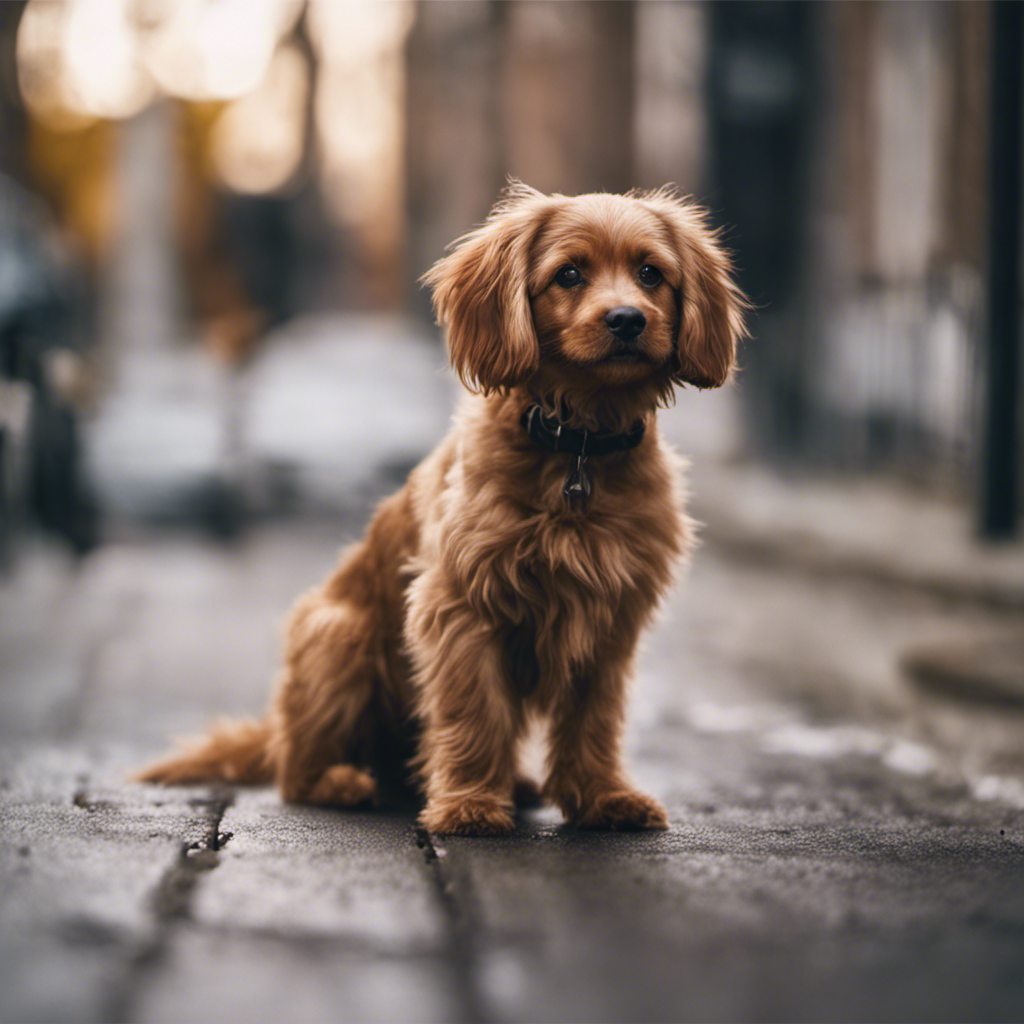

In [9]:
# Get this working first.
show_b64_image(text2img_response_sync("A dog"))

In [ ]:
#@title Step 5. Change it to Async
async def text2img_response(content):
    api_url = f"https://pas4ai.rorytm.com:8001/proxy/bedrock/stability.stable-diffusion-xl-v1"
    print(f"{content=}")
    base64_bytes = b"iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAABhGlDQ1BJQ0MgcHJvZmlsZQAAKJF9kT1Iw1AUhU/TSotWHOwg4pChOlkQFXHUKhShQqgVWnUweekfNDEkKS6OgmvBwZ/FqoOLs64OroIg+APi6OSk6CIl3pcUWsR44fE+zrvn8N59gNCoMs0KjQGabpuZVFLM5VfE8Ct6EEAIEYgys4xZSUrDt77uqZfqLsGz/Pv+rF61YDEgIBLPMMO0ideJpzZtg/M+cYyVZZX4nHjUpAsSP3Jd8fiNc8llgWfGzGxmjjhGLJY6WOlgVjY14kniuKrplC/kPFY5b3HWqjXWuid/YbSgLy9xndYQUljAIiSIUFBDBVXYSNCuk2IhQ+dJH/+g65fIpZCrAkaOeWxAg+z6wf/g92yt4sS4lxRNAl0vjvMxDIR3gWbdcb6PHad5AgSfgSu97d9oANOfpNfbWvwI6NsGLq7bmrIHXO4AA0+GbMquFKQlFIvA+xl9Ux7ovwW6V725tc5x+gBkaVbpG+DgEBgpUfaaz7sjnXP7t6c1vx/69HJ3FGcNLgAAAAZiS0dEAAAAAAAA+UO7fwAAAAlwSFlzAAAuIwAALiMBeKU/dgAAAAd0SU1FB+YLAQQKGC0v3EsAAAAZdEVYdENvbW1lbnQAQ3JlYXRlZCB3aXRoIEdJTVBXgQ4XAAALGUlEQVR42t2beXBV9RXHv+f3u/e+JXnZIIADRSkCAiIgsrZFhAgkIaxZAevWTt3YRBEBnemUZVxZymBnrFIoRELYZBekWiwUBEQqyDrSquwhZM+72+/0D6kNSCDk5T2W8++979yczzu/s3zvC3Cb25qneus7nuluVHedbsegtzzXne7QKjtEc9lQwc4IhvCf1ps07fzWVuvye7XbKfCDYzvc7UdFulSnH5HKaQPwj9fYdu4F8MVtB+Dg8/c38rslIwV4uFTn2xNYXOm+aM+Vk/2WBHBgTPuGfpjDNFiZ0in4JUHJa31GCNzaAD4f3SUhUZSmaWwOlXwhmaD06/l8NfHf3AD2PN/dn6CK+kplPiFxJlUoV9TaGd0iAI6Naa0TKFWHlSndUwMEO4G68Es3cwZs+V0nranXfMgDM12icrBgp0GdP+Rmy4BNT3UWzXzBB7yqIotQOEKy3TCMj2O4TulNAeDAqHZdAiKYKVCQIV2nadVeHZ7Ihe1Cvt3i9Z1Hb9gkeHhc+9Y+VZENVtk6rJYRCNpxSd/mQMsvQ/TydrP3nI74KHz4+Q53et2KHAFnpGS7LYU/aHagH3ShLYbUFzabuf/7UIpjrezQuPubeFV5pgY7XbDTnaDCnFsEF9ohRXJBOQWWtZ6191hddYca275xnRPjuGSwZCtbsPtgTaayUM0l44jD2moLxuKjZf59qe9/zrVHWJtePfqeGI3UUAl3hGTnQYKrhz1o6Cdc0lY4rC9uPufrnWHujj+1z57tEttYL0vR2Rwm2EkRcH0RCLoQRLlBisorQmD7A7O2q7o/RFex7aO6eO6QJUkGmyPAKl1E4JtWpF9QEKtMeJeedOM+6Tl3mxmKvzET5rZXwrjTS+baN2aMUtecA06OaymDrD0slfW4RuceFsqOD3vQ0CpcyHUu6XlB+Fa3nr3Xrq2vsa/MJ2VVtlCgkURymEuiNQAKWqovgM1XBXDsxa6kzDOrfahIudhbwhi0tBW0jTYZiytE1Np7Z+4uD8XfqPEzm0HzDXUdZzgLowMAUfXP1+E2uOYkqN+X1KleQKY4ZWWwzp2EdeoQECyou15N0nZZ+9QhPa8YgVUdZu86H1J6vzinoZLeDBClM9AToGqPtKAaCCKO8DTXdAEtPgHe+ATw3W1hlhTBOnui1jAYAi607Q7p+UF4F7Wesy8komMmzktQpA1gpR51hfwVQDWqS6I2yxAJgjcuHt64eHCLtrBKS2AVnIZ18gi4/MRVgiY4MPaw0BaVKv+Ke+fs/Tak9H5hVgBCT4PQMl2S/QB4q5V4qusowpAhLUNEBE9MLDwxseBmLWGVlcI6exLWqaMXYRC7pO+3WVtXSb6FbWbvOxhK0KNfmO2B0PqzNLIYGABQSLqAKTy+OtsGiQieQAw8gRjwz1vBqawEM+80oqJfI0FbtORJpbXxO+6lPxouGT0ZNFwBQ0AiLtwdKOR1mIig+/0A0A3glay42Fw79WNHYbnLtDZm0OSrwhg/aZ6wHPQAyWybKB0kwqILEFhFSg+IFYRhhsQwxVxhrZu6iYAVRLReS5l8HgDGTpkvlGPez6Ask0U6JN0V7qFSc81d126DEnZdPlUQ/AAGAxjMzJWnlk7/bNa++CPljpMK0ppFQIpQxO5eYjVt5uvPfXlNAPX84iAAhepV5Ou2ckvg6AUPvjzn9X1VZPRVoL5hl2FY7SdgiXQq82a9OeZYjWuA19AO2Y7zewG8SITo2j4/6BC+ueDBvwq82FPogcPhF56I1VGwyoNjLncqy/e9M28S16w2XMFKP5wWIwX30wWGAEgBEHstR7YLHC/y4ouzXuy94IGlIqC2sfqeWK0kogWke/bO/sNj6vqL4zXM2TDd57qqDzPSBSGNCAn/D5rwn2IDB8578XmBBxWuiMCx5rPEvEwoe4mUYtvbM54OaUW+rq+paNU0b4VFgwsqPG/+u0Rv/I+z3ogE3cDjoGuiiSbR5j8bx9jjA365U/abWCfaQI0AjJs4z+ew6MvACAiZDFB0uIOO1Vx0STTRoUElGkXbl8/yhx2Fda5CXpRP2019aw+Dql86/qSxcpJYGNlMNBCgsOsCMZpCt8QgWtcL4mcxFmQNkksxjhOwigStJBI7tOSX7ZAAjJ04r5EL+SqDMkCifriD9kuFTgkm2iUGcWesBUOGJEJ85zI22i7yXIitcYMm2dcF4LWnHiH3rqRd5TY6lVTYYdNDdGJ0iLfQsUElmseboQZdXWacY2C5JFojhNgsq8mMSwDkr9wepxgXQATLDKLwQinOFRajpMysA4WfQcCuNjHWJ1mtipOiPaojRejNFAMHBFFPLWVy4U+m1UsVG6H9T1QxPF40apSIdm3uRteOLXBPs4aoH+OtVlioVgRitZ+U8yqZ5W3gmF2ffvnZl+L89IDloqWjMEkxdl+cPsM3JAFtbZczar0MabqBxMT6SEysD8e2cKGoFAWFxSgsqYTiK05l3zCrZYKwSOie/bP+8Pgld4n+LzOAYwBmAJhhr5vWlJkHAsgAoQeFYUkrNfmOOtkGf4BRD4mJ9eA6DoqLS1BQWILCorLTjkKucIN5Qlm7Zr41vsYHW0+d/C2AuQDmlnw4tbEuMEgQMgWhGwBPXQAwZBj0AKlpSKiXgIR6CWClAszclJVzV7Cy7GsAZbVqhYOmnAAwD8A8Z/20RKU4hYEMIvQhwFvrwiuvrB1ecqKXrtpRn5nPhV51uJxZbYRy84l4bVZ6r/JQXRaunJrg05AmCOmC0Au47mVtlp46ZVxkAFzCQgWVUlvBnGeb5asfHZkcss7urJ8eq1j1BpDBjAGCEKgTAHkrt8WCqegq8nqoNGxm9TdmtYwda9Xw7KSQYZxdPi0qWud+QiBTEvoAqF9rAAsWbybD69sphOwc/ubMtqvc3axUvnLt/Edykr4POTM2TPezUj0ZGMKMwYLw49sgV+ENb9qUCdcchRct2dJA1z2jGcgmIZtHYlABs2LmHWCVrxxzxfDspG9DdWmtn6GbtttLF8ggQhdHYXTUwClba7wM/fndfOGNjusoNU8GSKQLGSEYgGLl7lNKrbTt4DLDE3UoZ9gvwvaWskaHfcPfj1PhiSNtpMc/GBDpRNQhbHXi0swAM38FqHx27WU5mb0P3hAAPzkmuR+1kro3HSQyhNTuQ2RmemblHlas1ri2lV9aVrznmd8OUzcEQFWb/5c1Lf2BuP74YX3uASIRkbKh3OMAL2Pl5mve2N0ZaR35hgCoarlLNjcmaQwDiUwhZDcQyQjB+E4xr3MdK98KVnz25GNp9g0BUNXem7+6cXQgrh+ESAdEHxAZEWooZ1iplVDOMmn4Ps0c3M29IQCq2uLFG+oJw58GElkkRG8iEREYYHXGVepjAr+Tk95z2w0DUNXefX91QlR0IFlKfRBIJIPCL7CCmZVrpeRk9Np4wwFUtb8uXB2l+WKSiWQGSKSQEGGEwW9kDekx4aYCUNUW5m72C6J+uuFNBdEQkEioS/+2Zb43MqvXb25aAJe01vdWGN5A/EMktEwQDSQhQ1anzWBF7q9z+oyoU0EkXPb4k0MtAB8B+Gjh4k06EXoZHn8yiDJAokmt+n01k+st9Z+jS1ftFE6wtBtpRiaRGEJCNq3xETArc0dm9x5xSwO45JgsWCeEFN28vkB/EDJAstXV4nGsYO6IrIduHwCX2wd5W9pBaJk/bK7aPZdfd61g7vArABC3C4CcrD5f5WQ8+ErhuZNtKsuK2kM5E8Dublz8cRQJUXzL14Ba7ScfbGomNKNPRUX5liceTT1++fX/Am9zpgf9WJY9AAAAAElFTkSuQmCC"
    text = None
    return base64_bytes, text


In [ ]:
#@title RUN

asyncio.get_event_loop().run_until_complete(bot.start(DISCORD_KEY))
